<a href="https://colab.research.google.com/github/jamarju/demo_orla/blob/master/03_entrena_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instrucciones

In [1]:
!pip install fastai

In [2]:
from pathlib import Path
from zipfile import ZipFile

import multiprocessing

from fastai.basics import *
from fastai.vision.all import *
from fastai.distributed import *

In [3]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_d = Path('/content/drive')
else:
    data_d = Path('data')

In [5]:
temp_d = Path('temp')
temp_d.mkdir(exist_ok=True)

In [6]:
%%time
if not (temp_d / 'crops').exists():
    with ZipFile(data_d / 'crops.zip', 'r') as z:
        z.extractall('temp')

CPU times: user 42 µs, sys: 0 ns, total: 42 µs
Wall time: 42 µs


In [7]:
crops_d = temp_d / 'crops'

In [8]:
crops_d.ls()

(#2) [Path('temp/crops/train'),Path('temp/crops/valid')]

In [9]:
%%time
dls = ImageDataLoaders.from_folder(
    crops_d,
    item_tfms=Resize(128),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    bs=1024,
    num_workers=multiprocessing.cpu_count(),
)

CPU times: user 45.4 s, sys: 426 ms, total: 45.8 s
Wall time: 45.8 s


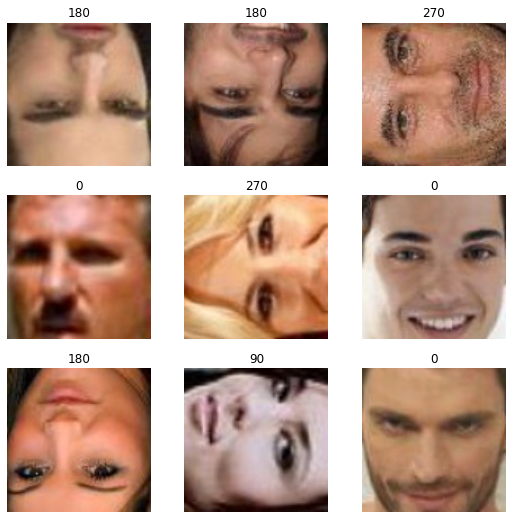

In [10]:
dls.show_batch()

La arquitectura que hemos elegido es Resnet-18 que, en la familia de las resnets, es la más pequeña con una profundidad de 18 capas. Podemos probar con redes más grandes: resnet34, resnet50, resnet101, resnet152 simplemente cambiando el parámetro `resnet18` a continuación por cualquiera de los anteriores y veremos que la precisión de la detección **mejora** pero, ¡ojo!, cuanto más profunda sea la red más tardará y más RAM de la GPU usará. Si nos da errores de RAM ('CUDA OUT OF MEMORY') tendremos que reducir el tamaño de lote (`bs`).

In [11]:
%%time
learn = cnn_learner(
    dls, 
    resnet18, 
    metrics=[accuracy, error_rate], 
    path='.',
    pretrained=True,
).to_fp16().to_parallel()

CPU times: user 458 ms, sys: 55.4 ms, total: 514 ms
Wall time: 172 ms


# Entrenamiento

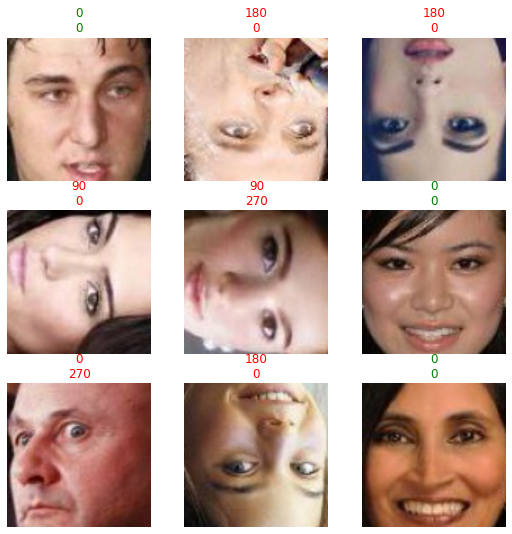

In [12]:
learn.show_results()

Vamos a utilizar una técnica llamada aprendizaje por transferencia (_transfer learning_) o afinado (_fine tuning_) que se utiliza cuando tenemos pocos ejemplos y acelera considerablemente el entrenamiento. Consiste en partir de una red neuronal **previamente entrenada** para cualquier otra tarea y **afinarla** a nuestro problema concreto. En concreto, la resnet que estamos utilizando ya ha sido previamente entrenada para clasificar el conjunto de datos ImageNet, de 14 millones de imágenes, en 1000 categorías distintas ("perro pekinés", "guitarra eléctrica", "reloj de arena", etc).

El 2 es el número de _epochs_  e indica el número de veces que hacemos circular por la red el conjunto de datos completo. Es un número que se estima a ojo. Podéis probar con más _epochs_ y posiblemente consigáis mejor precisión a costa de un mayor tiempo de entrenamiento

También podéis ver qué pasa si entrenáis una red desde cero si en la llamada a `cnn_learner` usamos `pretrained=False` en lugar de `pretrained=True`. Anticipo: debería aprender mucho peor y necesitará muchos más _epochs_.

In [25]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.080756,0.030469,0.988873,0.011127,02:07


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.001891,0.000858,0.999685,0.000315,02:19
1,0.000806,0.000374,0.999833,0.000167,02:20


In [26]:
learn.export(data_d / 'tiltnet18.pkl')

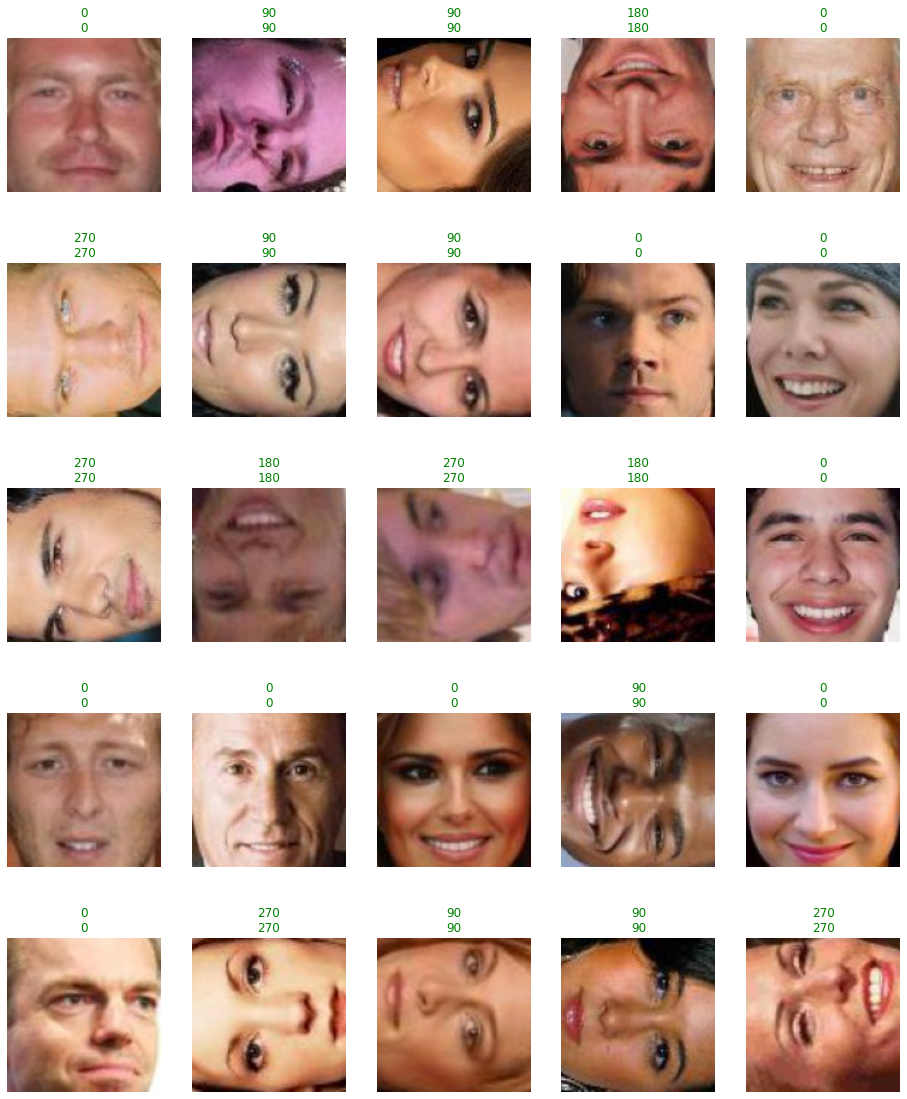

In [27]:
learn.show_results(figsize=(16,20), max_n=25)

In [28]:
preds, targs, losses = learn.get_preds(with_loss=True)

In [29]:
preds

tensor([[1.0000e+00, 2.3688e-06, 1.3976e-08, 3.0526e-08],
        [1.0000e+00, 6.6156e-08, 2.7150e-08, 3.9350e-08],
        [1.0000e+00, 1.9674e-07, 2.0176e-08, 2.8901e-08],
        ...,
        [5.6910e-09, 6.2994e-09, 1.0000e+00, 4.8314e-07],
        [5.6807e-08, 5.4845e-08, 1.0000e+00, 4.1574e-06],
        [2.8954e-09, 3.7763e-09, 1.0000e+00, 3.4126e-07]])

In [30]:
preds = preds.argmax(-1)

In [31]:
preds

tensor([0, 0, 0,  ..., 2, 2, 2])

In [32]:
targs

TensorCategory([0, 0, 0,  ..., 2, 2, 2])

In [33]:
df = pd.DataFrame(data={'preds': preds, 'targs': targs, 'losses': losses})

In [34]:
df

,preds,targs,losses
0,0,0,2.384183e-06
1,0,0,1.192093e-07
2,0,0,2.384186e-07
3,0,0,7.152555e-07
4,0,0,-0.000000e+00
...,...,...,...
162031,2,2,8.344647e-07
162032,2,2,-0.000000e+00
162033,2,2,4.768370e-07
162034,2,2,4.172316e-06


In [35]:
df.sort_values('losses', ascending=False)

,preds,targs,losses
20187,1,0,4.179516
84670,2,1,3.183431
61938,0,3,2.679771
101229,3,1,2.657823
20211,2,0,2.430759
...,...,...,...
111191,1,1,-0.000000
111190,1,1,-0.000000
111189,1,1,-0.000000
111188,1,1,-0.000000


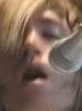

In [36]:
dls.valid_ds[20187][0]

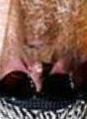

In [37]:
dls.valid_ds[84670][0]

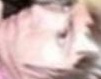

In [38]:
dls.valid_ds[61938][0]

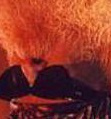

In [39]:
dls.valid_ds[101229][0]

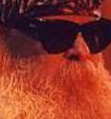

In [40]:
dls.valid_ds[20211][0]

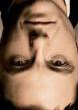

In [41]:
dls.valid_ds[111560][0]